In [1]:
import os, sys
import functools
import tempfile
import multiprocessing as mp
from typing import *

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.auto import tqdm

from biotite import structure as struct
from biotite.structure.io.pdb import PDBFile

from foldingdiff import tmalign, nerf, utils, plotting
from foldingdiff import angles_and_coords as ac

PLOT_DIR = os.path.join(plotting.PLOT_DIR, "lever_effect")
assert os.path.isdir(PLOT_DIR)

In [2]:
# Taken from 250 partial noise
average_test_error = pd.Series({
    'phi': 0.002905,
    'psi': -0.009807,
    'omega': 0.009512,
    'tau': -0.000435,
    'CA:C:1N': 0.002994,
    'C:1N:1CA': -0.000519,
})

std_test_error = pd.Series({
    'phi': 0.35128071904182434,
    'psi': 0.35357287526130676,
    'omega': 0.26199206709861755,
    'tau': 0.055109016597270966,
    'CA:C:1N': 0.052058733999729156,
    'C:1N:1CA': 0.05673425272107124,
})

average_test_error

phi         0.002905
psi        -0.009807
omega       0.009512
tau        -0.000435
CA:C:1N     0.002994
C:1N:1CA   -0.000519
dtype: float64

In [3]:
test_perturb = average_test_error + 0.5 * std_test_error
test_perturb

phi         0.178545
psi         0.166979
omega       0.140508
tau         0.027120
CA:C:1N     0.029023
C:1N:1CA    0.027848
dtype: float64

In [4]:
def sweep_angles_for_tmscore(
    fname: str,
    deltas: Optional[pd.Series] = None,
    scalar: float = 0.2,
    disable_pbar: bool = True,
) -> np.ndarray:
    """
    For each angle in the structure, perturb it by scalar * deltas, reconstruct
    and measure TM score with respect to the original structure.
    """
    f = PDBFile.read(fname)
    assert f.get_model_count() == 1
    structure = f.get_structure(1)
    angles = ac.canonical_distances_and_dihedrals(
        fname, distances=[], angles=ac.EXHAUSTIVE_ANGLES
    )

    if deltas is None:  # Set to std of each angle
        angles_0_2pi = angles.copy() % (2 * np.pi)
        deltas = angles_0_2pi.std(axis=0)

    # Function to take the angles back to [-pi, pi]
    recenter = lambda x: (x + np.pi) % (2 * np.pi) - np.pi

    # reconst = ac.create_new_chain_nerf(angles)
    retval = np.ones(shape=(len(angles), 3))
    with tempfile.NamedTemporaryFile() as tmp:
        # Write the set of angles into reference first
        reference = ac.create_new_chain_nerf(tmp.name, angles)
        # For each of the angles, perturb phi psi and omega
        for i in tqdm(range(len(angles)), disable=disable_pbar):
            for j in range(3):
                angles_perturbed = angles.copy()
                angles_perturbed.iloc[i, j] += scalar * deltas.iloc[j]
                angles_perturbed_centered = recenter(angles_perturbed)
                with tempfile.NamedTemporaryFile() as tmp2:
                    new_chain = ac.create_new_chain_nerf(
                        tmp2.name, angles_perturbed_centered
                    )
                    tm = tmalign.run_tmalign(new_chain, reference, fast=True)
                    retval[i, j] = tm
    retval = pd.DataFrame(retval, columns=deltas.index[:3])
    return retval
    
tm_deltas = sweep_angles_for_tmscore(
    "/home/wukevin/projects/protdiff/data/cath/dompdb/6nsjA00",
    disable_pbar=False,
)
tm_deltas

/home/wukevin/miniconda3/envs/foldingdiff/lib/python3.8/site-packages/biotite/structure/io/pdb/file.py:419: UserWarning: 1449 elements were guessed from atom_name.
  warn("{} elements were guessed from atom_name.".format(rep_num))


  0%|          | 0/182 [00:00<?, ?it/s]

,phi,psi,omega
0,1.00000,1.00000,1.00000
1,0.99999,0.99977,0.99999
2,0.99995,0.99922,0.99998
3,0.99979,0.99869,0.99998
4,0.99967,0.99826,0.99996
...,...,...,...
177,0.99947,0.99882,0.99998
178,0.99953,0.99909,0.99998
179,0.99966,0.99958,1.00000
180,0.99994,0.99997,1.00000


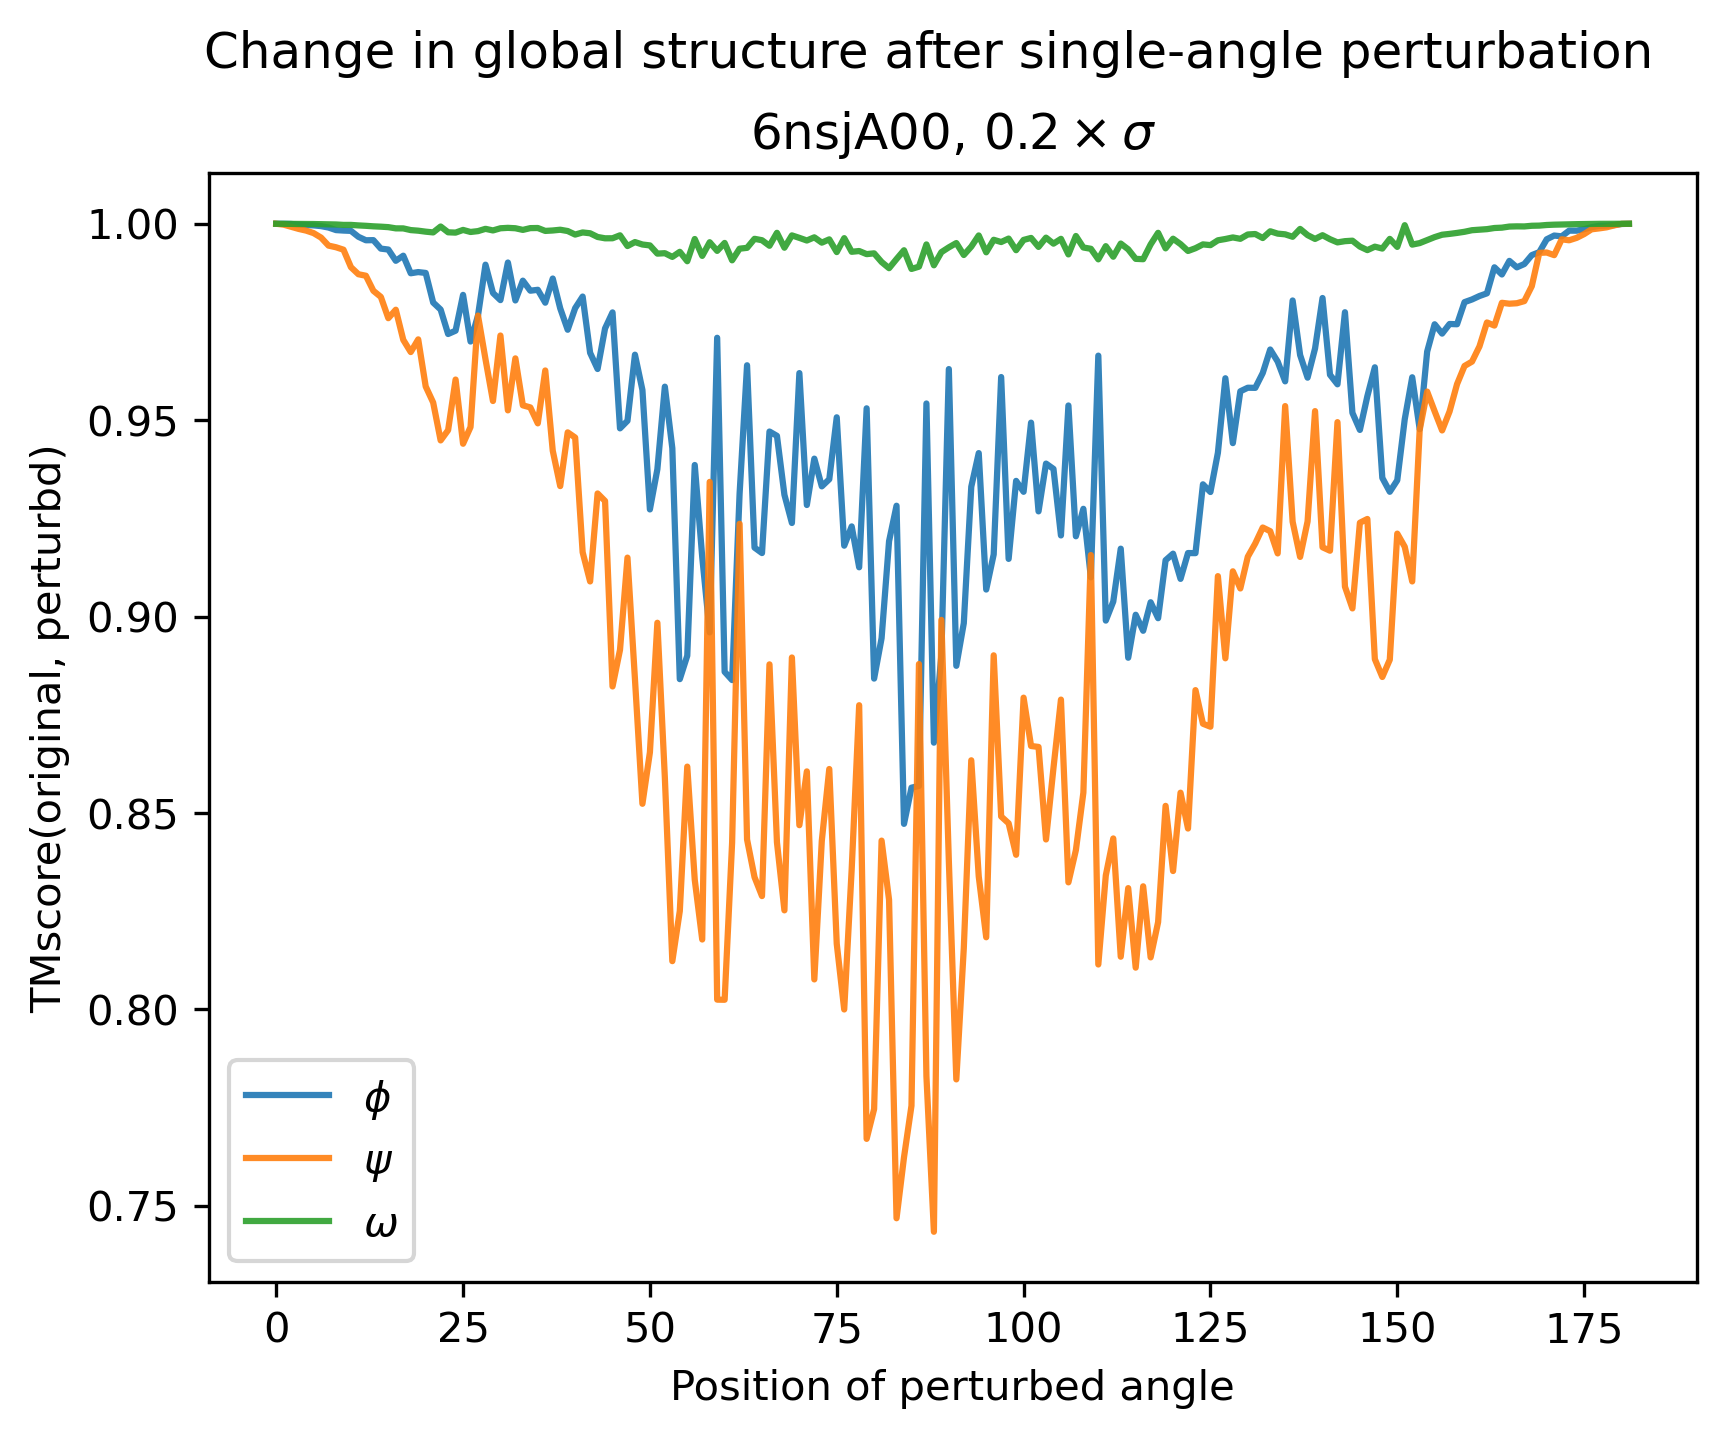

In [5]:
def plot_tm_deltas(
    tm_deltas: np.ndarray,
    fname: str = "",
    ax: Optional[plt.Axes] = None,
    disable_suptitle: bool = False,
    **kwargs
) -> plt.Figure:
    if ax is None:
        fig, ax = plt.subplots(dpi=300)
    else:
        fig = ax.get_figure()
    sns.lineplot(x=np.arange(len(tm_deltas)), y=tm_deltas[:, 0], label=r"$\phi$", alpha=0.9, ax=ax)
    sns.lineplot(x=np.arange(len(tm_deltas)), y=tm_deltas[:, 1], label=r"$\psi$", alpha=0.9, ax=ax)
    sns.lineplot(x=np.arange(len(tm_deltas)), y=tm_deltas[:, 2], label=r"$\omega$", alpha=0.9, ax=ax)
    ax.legend()

    if 'title' in kwargs:
        ax.set(
            xlabel="Position of perturbed angle",
            ylabel="TMscore(original, perturbd)",
            **kwargs,
        )
        if not disable_suptitle:
            fig.suptitle("Change in global structure after single-angle perturbation")
    else:
        ax.set(
            xlabel="Position of perturbed angle",
            ylabel="TMscore(original, perturbd)",
            title="Change in global structure after single-angle perturbation",
            **kwargs,
        )
    if fname:
        fig.savefig(fname, bbox_inches='tight')
    return fig

plot_tm_deltas(tm_deltas.values, title=r"6nsjA00, $0.2 \times \sigma$").show()

In [6]:
test_error_pfunc = functools.partial(
    sweep_angles_for_tmscore,
    scalar=1.0,  # Unscaled
    deltas=test_perturb,
)

cath_fnames = ["1xewY00", "2epdA00", "6nsjA00", "3l84A01"]
with mp.Pool(len(cath_fnames)) as pool:
    results = pool.map(
        test_error_pfunc,
        [
            f"/home/wukevin/projects/protdiff/data/cath/dompdb/{f}"
            for f in cath_fnames
        ]
    )
test_error_deltas = dict(zip(cath_fnames, results))

In [7]:
zero_two_pfunc = functools.partial(
    sweep_angles_for_tmscore,
    scalar=0.2,
)

cath_fnames = ["1xewY00", "2epdA00", "6nsjA00", "3l84A01"]
with mp.Pool(len(cath_fnames)) as pool:
    results = pool.map(
        zero_two_pfunc,
        [
            f"/home/wukevin/projects/protdiff/data/cath/dompdb/{cath_fname}"
            for cath_fname in cath_fnames
        ]
    )
zero_two_deltas = dict(zip(cath_fnames, results))

In [8]:
zero_five_pfunc = functools.partial(
    sweep_angles_for_tmscore,
    scalar=0.5,
)
cath_fnames = ["1xewY00", "2epdA00", "6nsjA00", "3l84A01"]
with mp.Pool(len(cath_fnames)) as pool:
    results = pool.map(
        zero_five_pfunc,
        [
            f"/home/wukevin/projects/protdiff/data/cath/dompdb/{cath_fname}"
            for cath_fname in cath_fnames
        ]
    )
zero_five_deltas = dict(zip(cath_fnames, results))

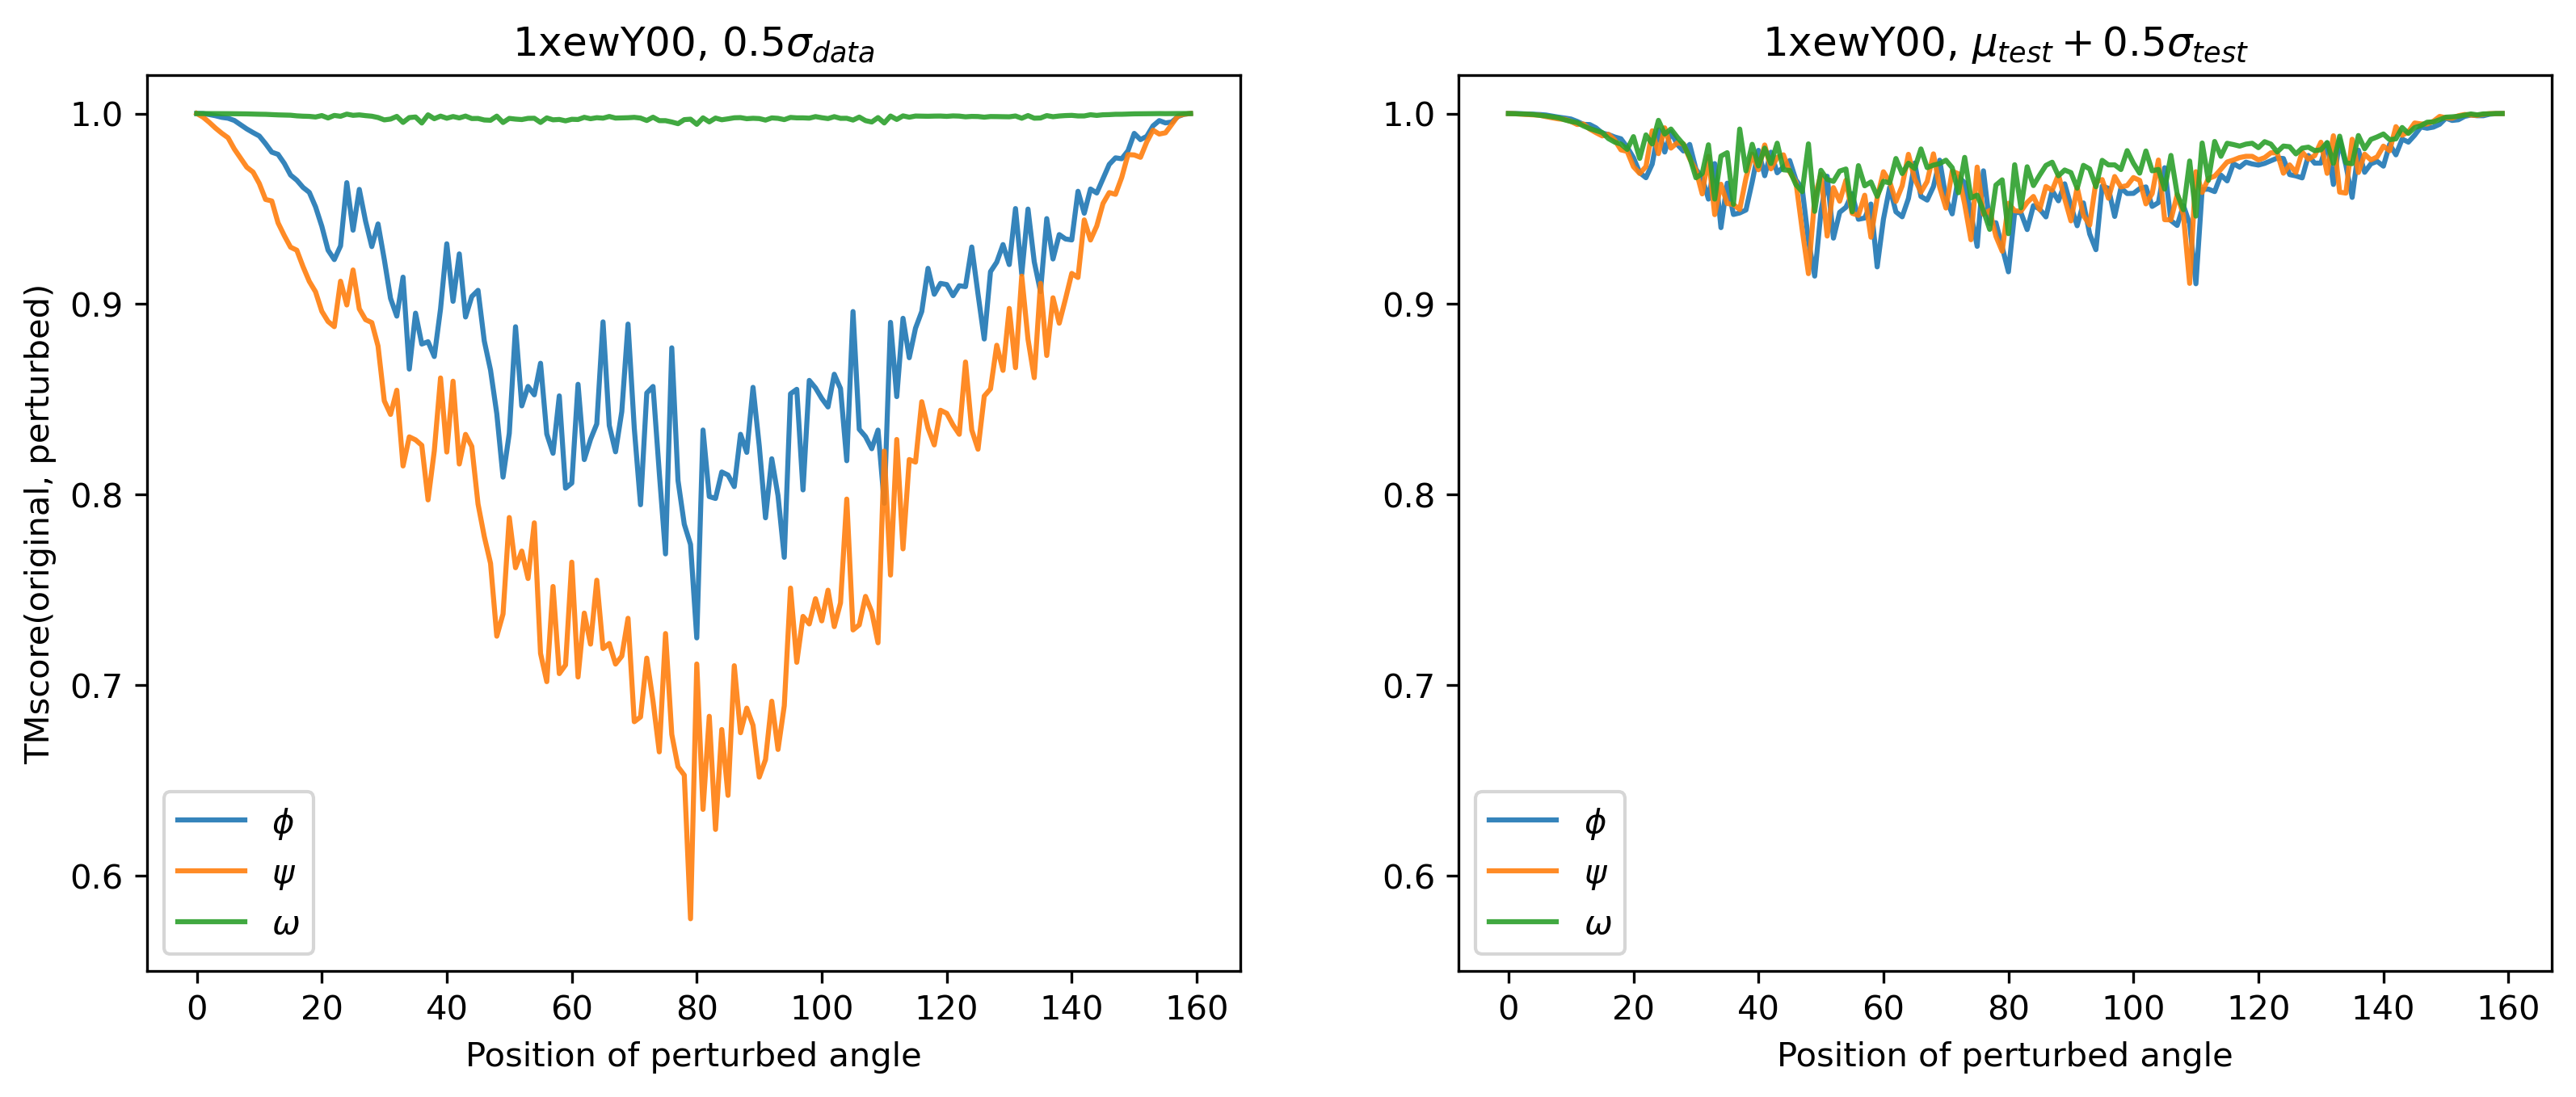

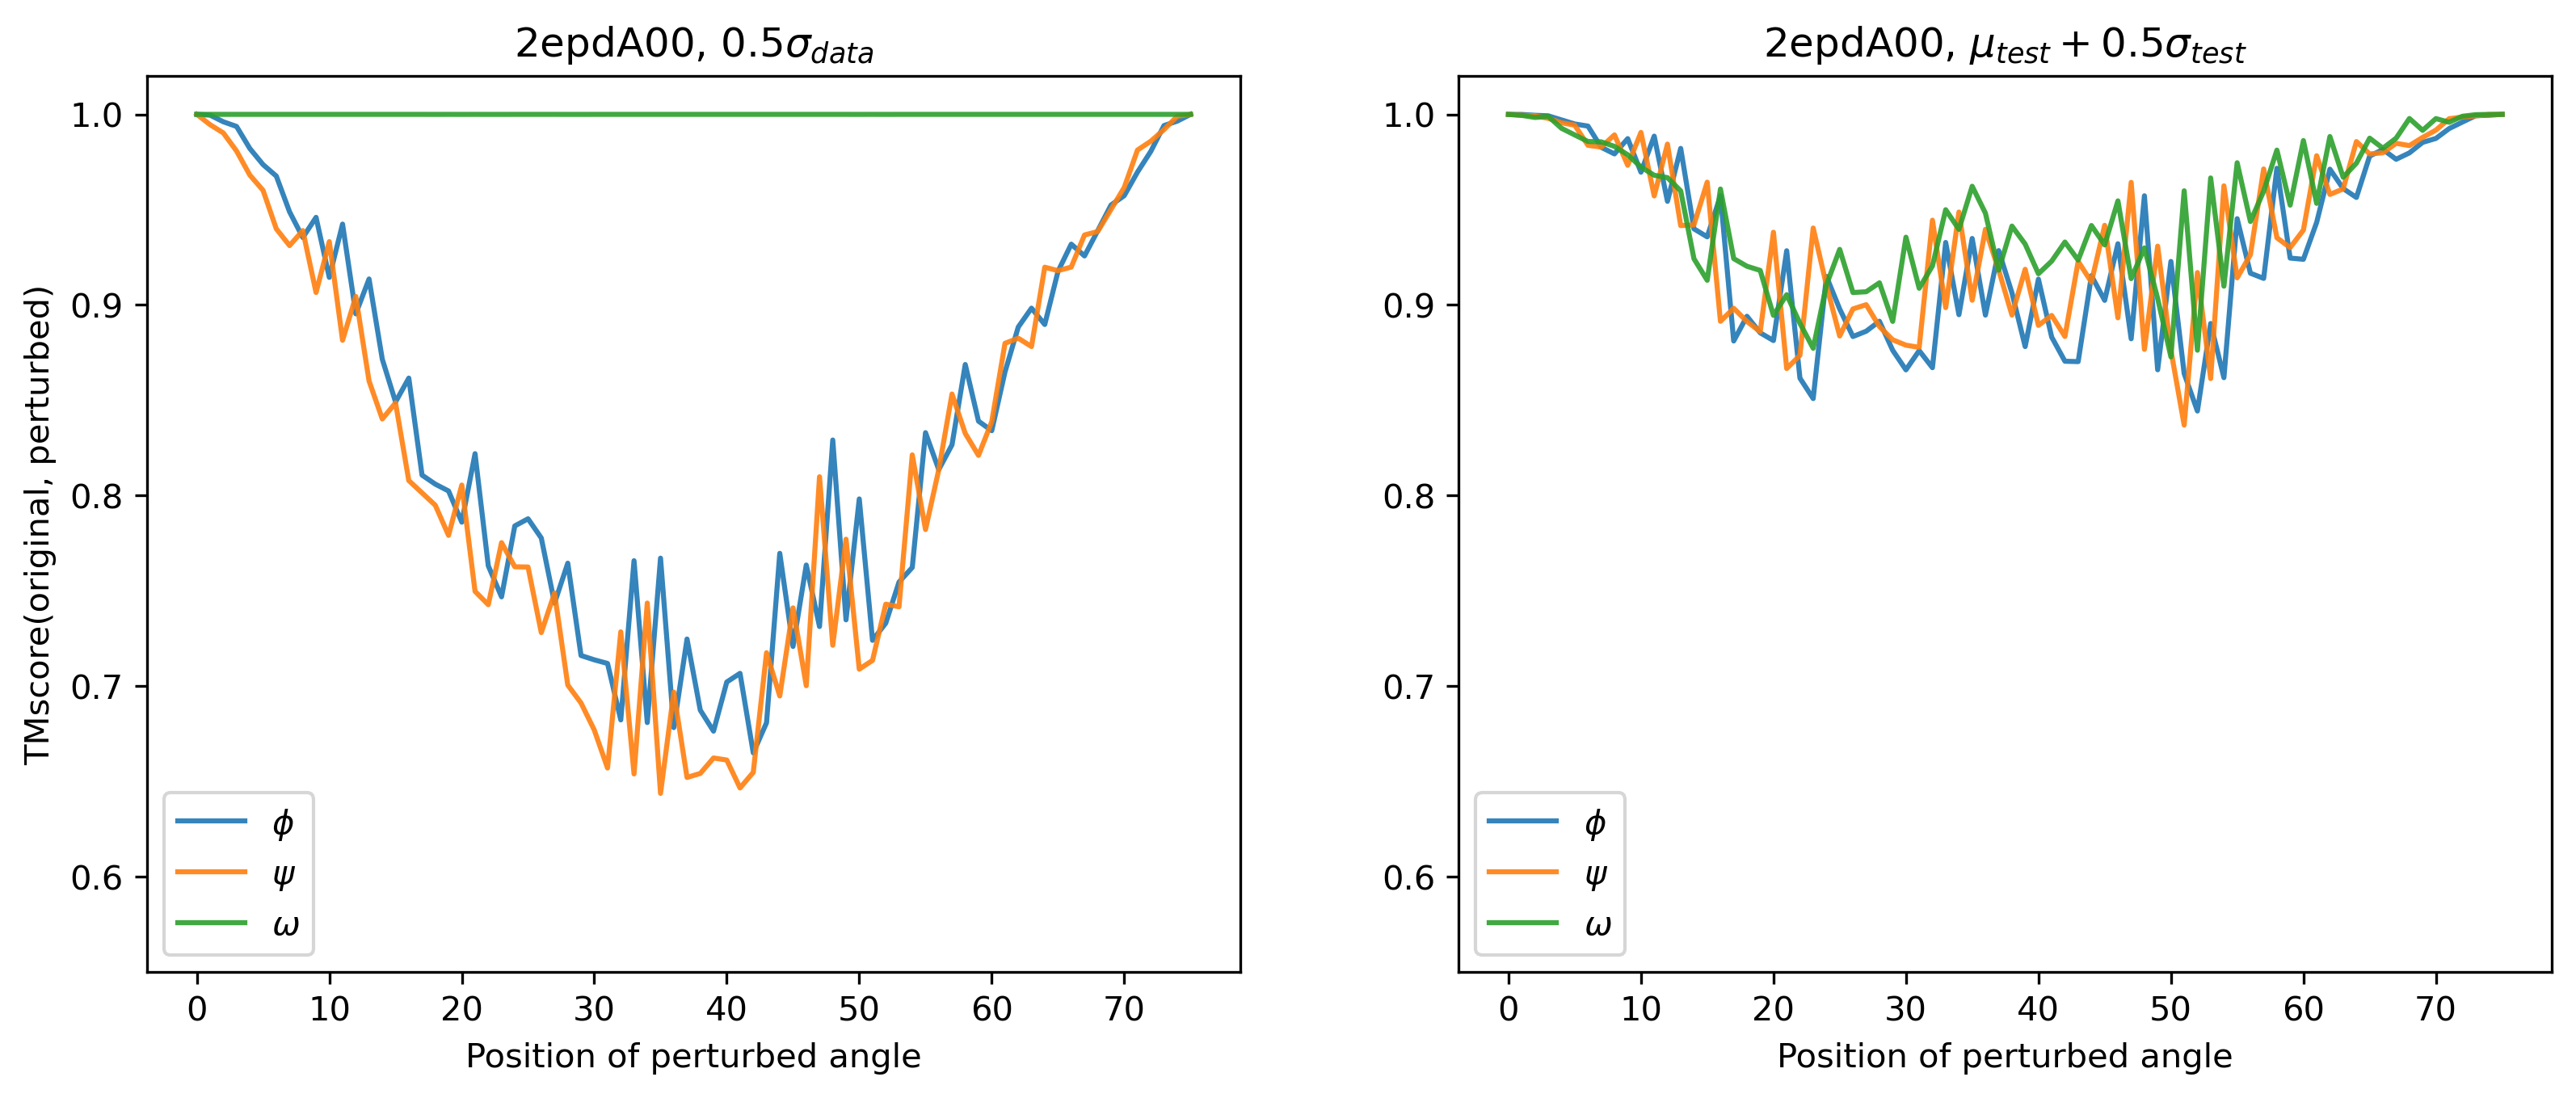

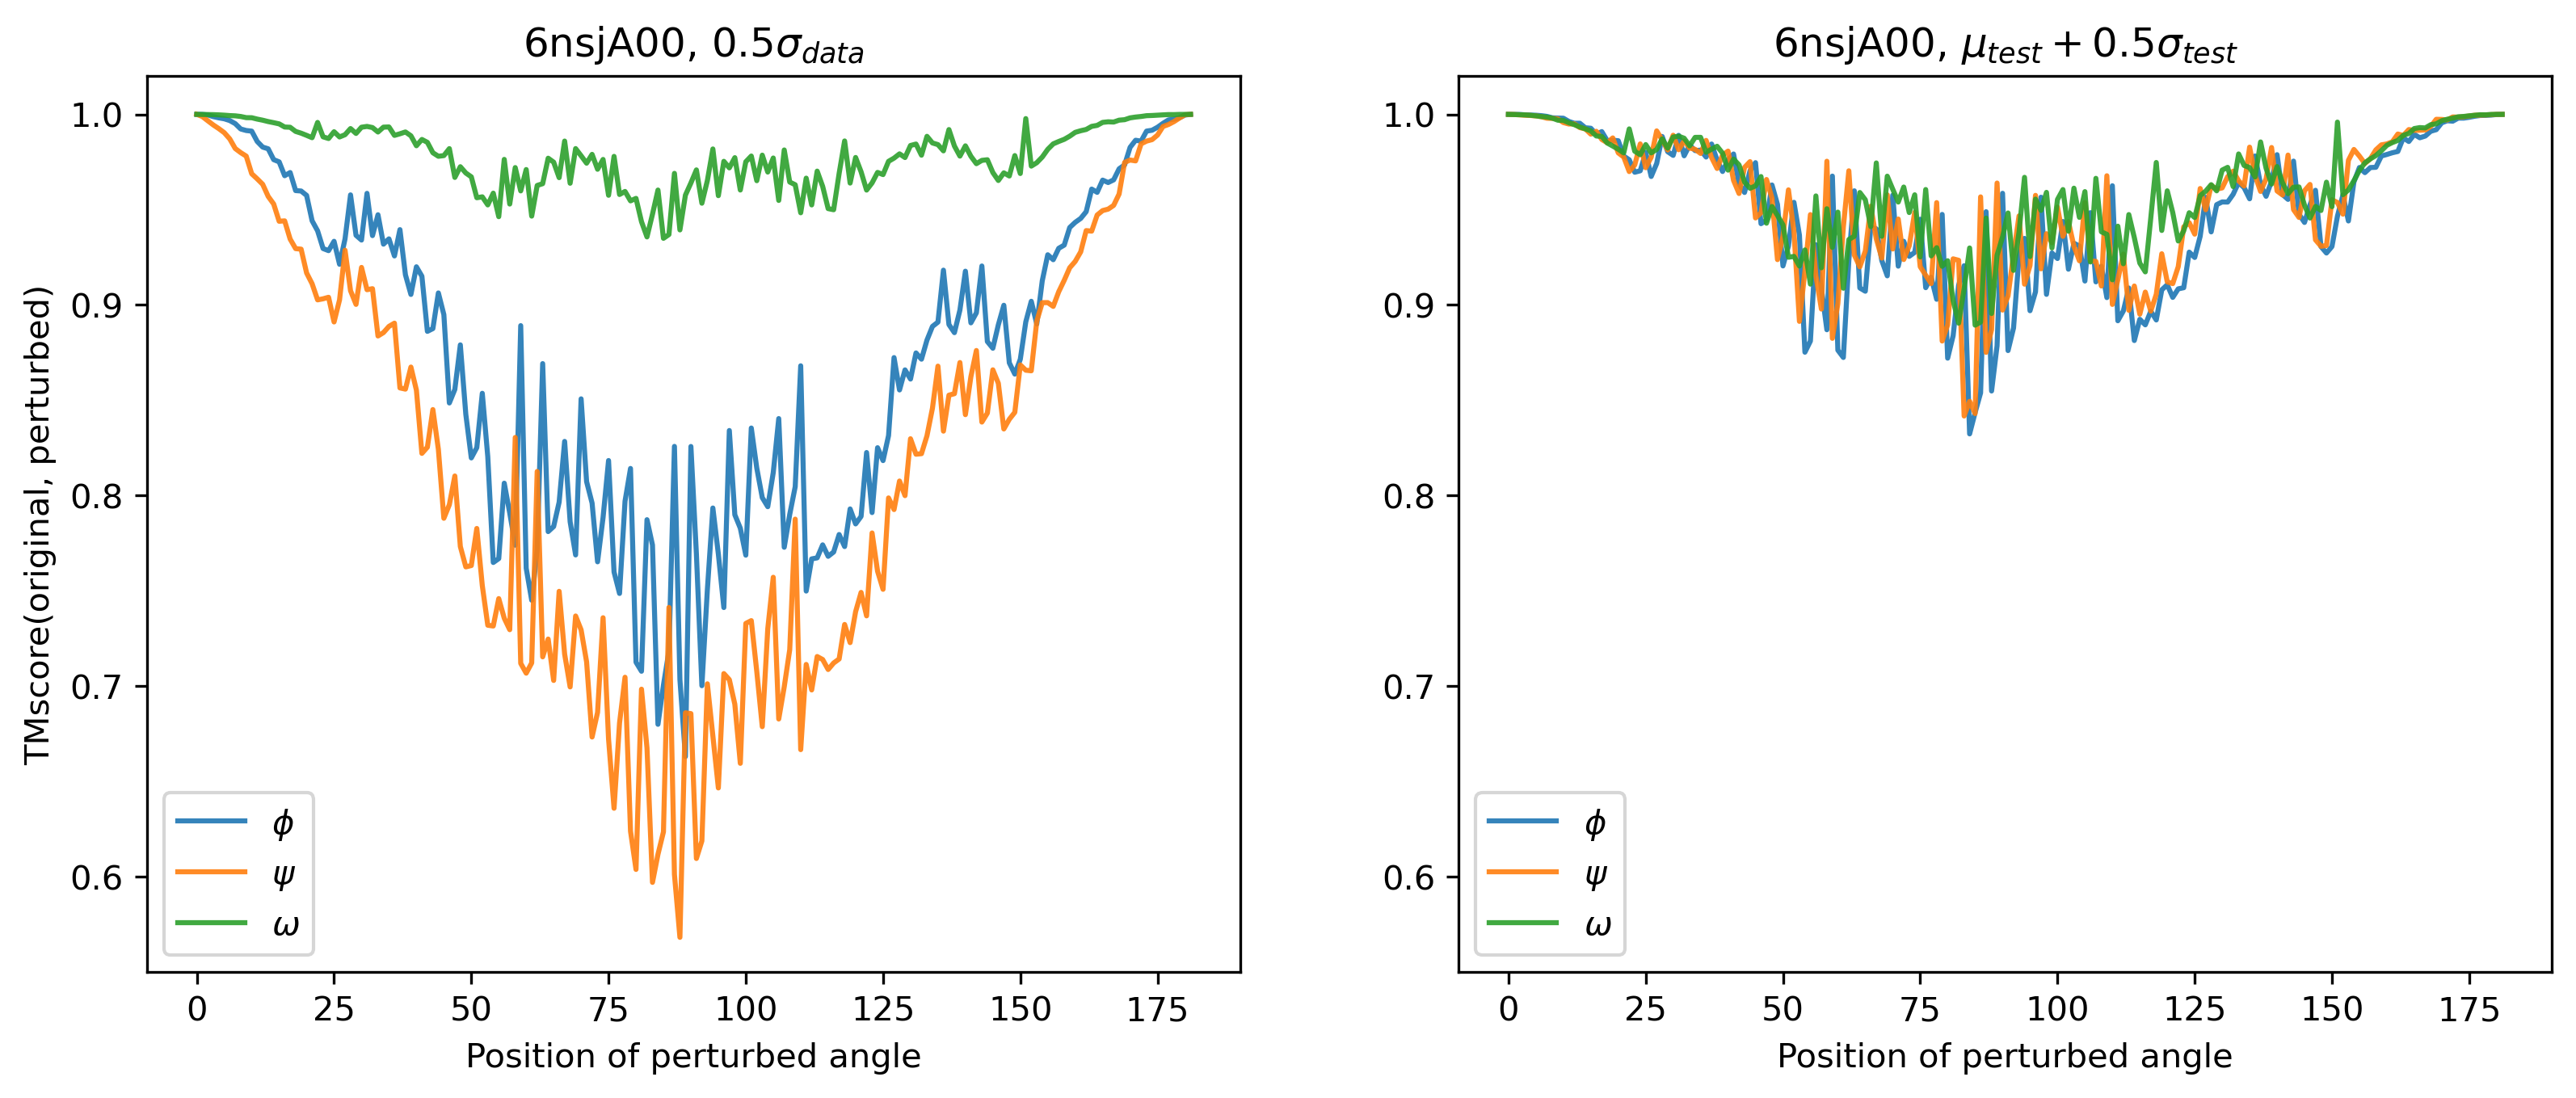

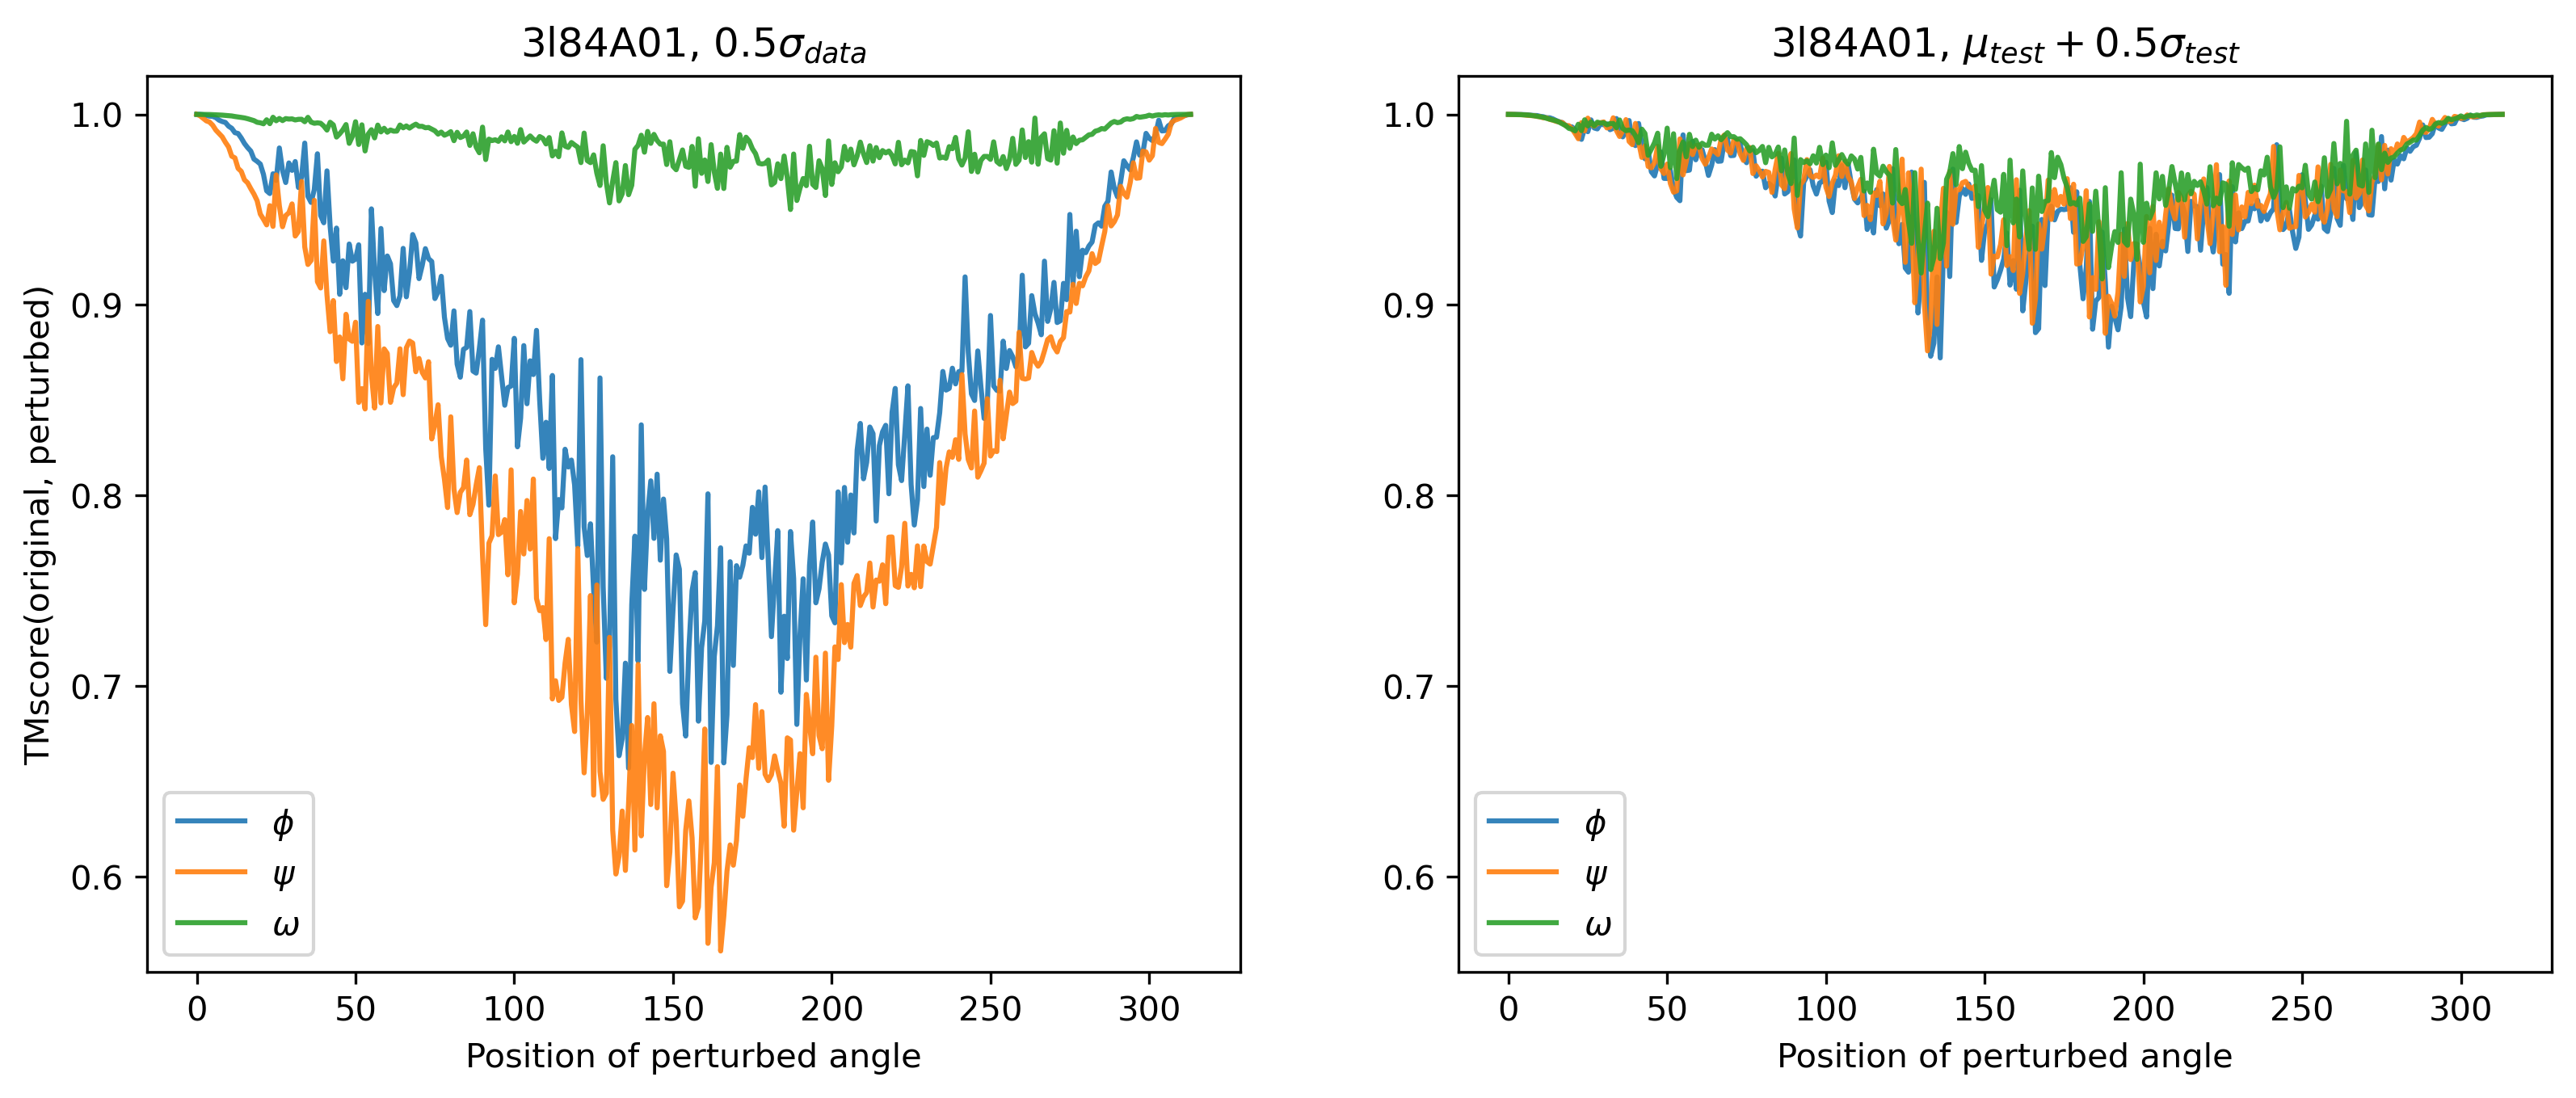

In [10]:
for cath_key in cath_fnames:
    fig, (ax1, ax2) = plt.subplots(ncols=2, dpi=300, sharey=True, figsize=(6.4 * 2, 4.8))
    plot_tm_deltas(
        zero_five_deltas[cath_key].values,
        ax=ax1,
        title=cath_key + r", $0.5\sigma_{data}$",
        disable_suptitle=True,
    )
    plot_tm_deltas(
        test_error_deltas[cath_key].values,
        ax=ax2,
        title=cath_key + r", $\mu_{test} + 0.5\sigma_{test}$",
        disable_suptitle=True,
    )
    for ax in (ax1, ax2):
        ax.yaxis.set_tick_params(labelbottom=True)
        ax.set(
            xlabel="Position of perturbed angle",
            ylabel="TMscore(original, perturbed)",
            ylim=(0.55, 1.02),
        )
    fig.savefig(os.path.join(PLOT_DIR, f"{cath_key}_combined.pdf"), bbox_inches='tight')
    fig.show()